# P5_XIRAN ZHANG

# Access to data in the cloud (GCS)

**If you run this notebook at colab.research.google.com, you need to install packages with the following command:**

In [ ]:
!pip install --upgrade dask distributed xarray zarr gcsfs cftime nc-time-axis intake intake-xarray

In [ ]:
import xarray as xr
from intake import open_catalog
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import datetime

## Use intake catalog of data

The catalog also uses the gcsfs entry point, but with intake it's transparent to the user:

### Access and listing of the catalog

In [ ]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2022/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
list(cat)

['argo_global_sdl',
 'argo_global_sdl_homogeneous',
 'argo_global_vertical_mean',
 'en4',
 'sea_surface_height']

### Connect to data

In [ ]:
ds = cat["en4"].to_dask()
print("Size of the dataset:", ds.nbytes/1e9,"Gb")
ds

Size of the dataset: 52.2317975 Gb


<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173, lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

We firstly have to calcalate the Ocean Heat Content . 
The areal density of ocean heat content between two depths is defined as a definite integral:
$$H = C \int_{h_1}^{h_2} \rho(z)T(z) dz$$
where C is the specific heat capacity of sea water, h2 is the lower depth, h1 is the upper depth, $\rho$ is the seawater density profile, and T(z) is the temperature profile. In SI units, H has units of Joules per square metre (J·m−2) . (via Wikipedia)

This function is used to filter out the data we want at a certain depth . The output is the depth of each layer after filtration, and the corresponding temperature of each layer . 

In [ ]:
def choose_depth(depth_bnds, temp, depth_limit):
    depth_bnds_limit = depth_bnds.where(depth_bnds < depth_limit, other = depth_limit)
    delta_depth = abs(depth_bnds_limit[:,:, 1] - depth_bnds_limit[:,:, 0])

    delta_depth_limited = delta_depth.where(delta_depth != 0, drop = True)
    temp_limited = temp.where(delta_depth != 0, drop = True)

    return delta_depth_limited, temp_limited

The function to calculate the areal density of ocean heat content is :

In [ ]:
def ocean_heat_content(delta_level_limited, temp_limited):
    rho = 1026 #kg/m^3, the mean density value
    c = 3990 #J/(kg K)
    ohc = (delta_level_limited*temp_limited*delta_s).sum("depth")
    ohc *= rho
    ohc *= c
    return ohc

Now we have the areal density of OHC, but we still need to integrate it over the area of each pixel to get the $\delta$OHC

Here we firstly built a matrix containing the actual area of each pixel .In order to compare with the data on the site:https://www.ncei.noaa.gov/access/global-ocean-heat-content/ , I chose to calculate the OHC above 700 meters

In [ ]:
R = 6371*10**3 #the radius of the earth
dy = xr.DataArray(np.ones(ds.lon.size)*np.pi*R/180,dims='lon') #Length of each lontitude
dx = xr.DataArray(np.pi*np.cos(np.pi*ds.lat/180)*R/180,dims='lat') #Length of each latitude
delta_s = dy*dx #Create a matrix

In [ ]:
temp = ds.temperature       
depth_bnds = ds.depth_bnds
delta_level_limited, temp_limited = choose_depth(depth_bnds, temp, 700)  #Calcalate the OHC over 700m
ohc = ocean_heat_content(delta_level_limited, temp_limited)

/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The OHC distribution at 1950 and 2019

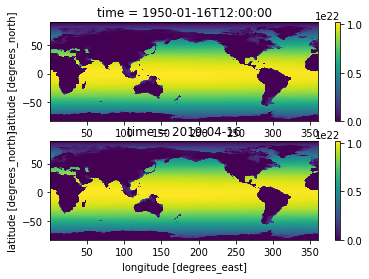

In [ ]:
plt.subplot(2,1,1)
ohc.sel(time = '1950-01-16',method = 'nearest').plot()
plt.subplot(2,1,2)
ohc.sel(time = '2019-04-16',method = 'nearest').plot()
plt.show()

Comments : We can't see a big difference here because the base of OHC is still large for it's growth . However, we can plot the difference between the two values to analysis of the local variation:

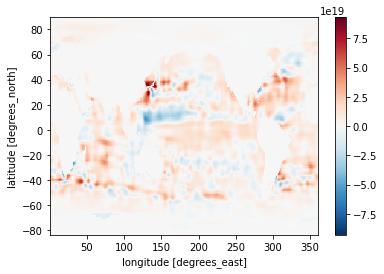

In [ ]:
ohc_1950 = ohc.sel(time=slice('1950-01-01','1950-02-01')).squeeze('time')
ohc_2019 = ohc.sel(time=slice('2019-01-01','2019-02-01')).squeeze('time')
(ohc_2019-ohc_1950).plot()

Comments : The greatest increase of OHC can be seen in the Bohai sea and Yellow sea of China . This reflects the China's industrialisation as well as the exceeded CO2 emissions has caused the rise in temperature of its nearby seas . 

Now, we analyse the variation of global OHC over time . We can plot the OHC anomaly time series . 

Text(0, 0.5, 'J')

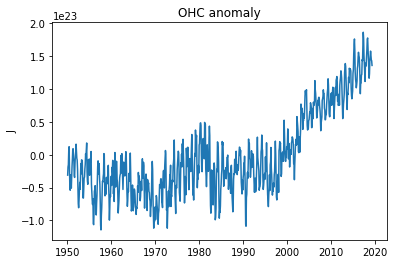

In [ ]:
ohc_total = ohc.sum('lat').sum('lon')
plt.plot(ohc_total.time,ohc_total-ohc_total.mean())
plt.title("OHC anomaly")
plt.ylabel('J')

To better understand the trends and compare with the data on the site:https://www.ncei.noaa.gov/access/global-ocean-heat-content/ , I have plot the quarterly (3-month) rolling average, the annual rolling average, the 5-year rolling average of the standardized data

In [ ]:
def standardize(x):
     return (x-x.mean())/x.std()

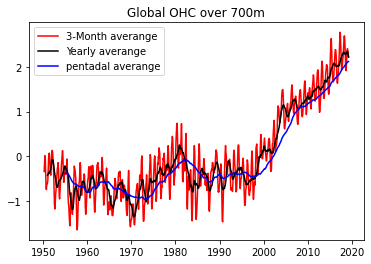

In [ ]:
ohc_y_av = standardize(ohc_total).rolling(time=12).mean()
ohc_3m_av = standardize(ohc_total).rolling(time=3).mean()
ohc_p_av = standardize(ohc_total).rolling(time=60).mean()
plt.figure()
plt.plot(ohc_3m_av.time,ohc_3m_av,label='3-Month averange',color='r')
plt.plot(ohc_y_av.time,ohc_y_av,label='Yearly averange',color='black')
plt.plot(ohc_p_av.time,ohc_p_av,label='pentadal averange',color='b')
plt.legend()
plt.title('Global OHC over 700m')
plt.show()

Comments : Although the global OHC has varied greatly over a short period of time, it is easy to see that it is on an overall upward trend.At about 2000,there is a dividing line: before 2000 the rate of rise was relatively flat and we can vaguely see a sinusoidal cyclical change; after 2000 the rate of rise increased significantly . 
We can also observe a slight difference between our calculated results and that of NOAA's National Centers for Environmental Information (NCEI). Part of the reason for this is that we have calculated the OHC with a rough approximation that we supposed the density and specific heat capacity of seawater was a constant, while in fact these variables vary with temperature, pressure, salinity and other factors

We use the linear regression method to predict the global OHC in 2100 . We started with training our model with all the data since 1950

In [ ]:
def t_predict(year):
  return np.arange(0,(year-1950)*12+1).reshape(-1,1)

In [ ]:
model1 = LinearRegression()
model1.fit(np.arange(0,832).reshape(-1,1),ohc_total)
ohc_total_hat = model1.predict(t_predict(2100))

I had to create a Dataarray with a longer time axis in order to plot the data we predicted for the future. There doesn't seem to be a directive like".append" in xarray .

In [ ]:
time = pd.date_range("1950-01-16", periods=1801, freq='M')

In [ ]:
ohc_filled = ohc_total.values
for i in range(1801-832):
  ohc_filled = np.append(ohc_filled, None)

In [ ]:
ohc_new = xr.DataArray(
    data=ohc_filled,
    dims=["time"],
    coords=dict(
        time=time
    ),
)
ohc_new.astype('float32')

<xarray.DataArray (time: 1801)>
array([2.8533446e+26, 2.8534687e+26, 2.8535034e+26, ...,           nan,
                 nan,           nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-01-31

Text(0.5, 1.0, 'Expected OHC For The Horizon 2100')

<Figure size 432x288 with 0 Axes>

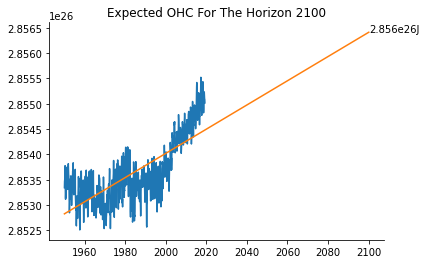

In [ ]:
plt.figure()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(ohc_new.time,ohc_new)
plt.plot(ohc_new.time,ohc_total_hat)
plt.text(ohc_new.time[-1].values,ohc_total_hat[-1],"%.3fe26J" %(ohc_total_hat[-1]/(10**26)))
plt.title('Expected OHC For The Horizon 2100')

Comments : Analysis using data after 1950 does not seem to accurately reflect future trends. This is due to the significant change in the rate of growth of OHC before and after 2000. We have to artificially choose the right model to analyse our data. However, the data after 2000 seems to show a significant linear trend and we can run a linear regression on the data after 2000

In [ ]:
model2 = LinearRegression()
model2.fit(np.arange(0,832).reshape(-1,1)[600:],ohc_total.loc["2000-01-16":"2019-04-16"])
ohc_total_hat2 = model2.predict(np.arange(1801).reshape(-1,1))

Text(2100-01-31T00:00:00.000000000, 2.8608079510178798e+26, '2.861e26J')

<Figure size 432x288 with 0 Axes>

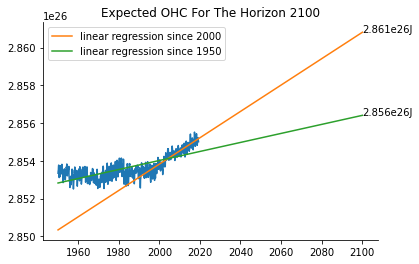

In [ ]:
plt.figure()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(ohc_new.time,ohc_new)
plt.plot(ohc_new.time,ohc_total_hat2,label='linear regression since 2000')
plt.plot(ohc_new.time,ohc_total_hat,label='linear regression since 1950')
plt.legend()
plt.title('Expected OHC For The Horizon 2100')
plt.text(ohc_new.time[-1].values,ohc_total_hat[-1],"%.3fe26J" %(ohc_total_hat[-1]/(10**26)))
plt.text(ohc_new.time[-1].values,ohc_total_hat2[-1],"%.3fe26J" %(ohc_total_hat2[-1]/(10**26)))

In [ ]:
print(model2.coef_)
print(((ohc_total_hat2[-1]-ohc_total[0])/ohc_total[0]).values)

[5.81314282e+20]
0.00261563502180996


Comments : Using this linear regression, we can derive the global OHC (layer above 700 m) growth : 5.81314282e+20 J per month .And until 2100, the global OHC will be 2.861e26 J, which means an increase of 0.2% compared to the numbers in 1950

Instead of study globaly, we can also study locally . We have divided the global ocean into roughly four parts as follows

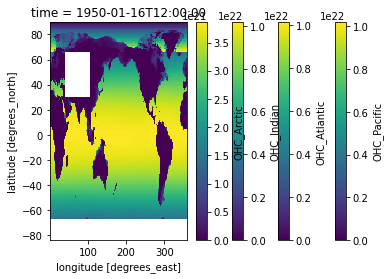

In [ ]:
ds['OHC_Pacific'] = ohc.where((ohc.lat>-66.5)&(ohc.lat<66.5)&(ohc.lon>105) & (ohc.lon<=260),drop = True)
ds.OHC_Pacific.sel(time = '1950-01-16',method = 'nearest').plot()
ds['OHC_Atlantic'] = ohc.where((ohc.lat>-66.5)&(ohc.lat<66.5)&((ohc.lon>260)|(ohc.lon<40)),drop = True)
ds.OHC_Atlantic.sel(time = '1950-01-16',method = 'nearest').plot()
ds['OHC_Indian'] = ohc.where((ohc.lat>-66.5)&(ohc.lat<30)&(ohc.lon>=40) & (ohc.lon<=105),drop = True)
ds.OHC_Indian.sel(time = '1950-01-16',method = 'nearest').plot()
ds['OHC_Arctic'] = ohc.where((ohc.lat>66.5),drop = True)
ds.OHC_Arctic.sel(time = '1950-01-16',method = 'nearest').plot()

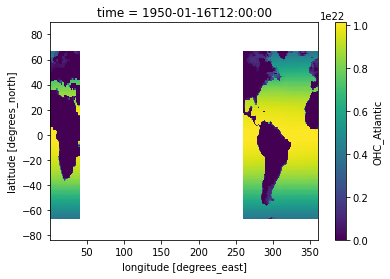

In [ ]:
ds.OHC_Atlantic.sel(time = '1950-01-16',method = 'nearest').plot()

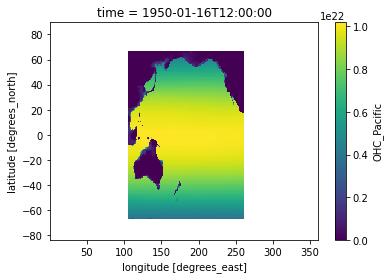

In [ ]:
ds.OHC_Pacific.sel(time = '1950-01-16',method = 'nearest').plot()

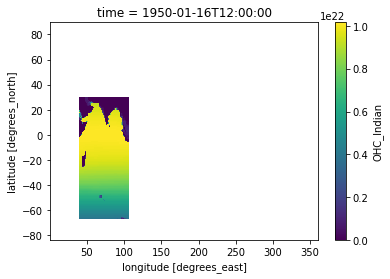

In [ ]:
ds.OHC_Indian.sel(time = '1950-01-16',method = 'nearest').plot()

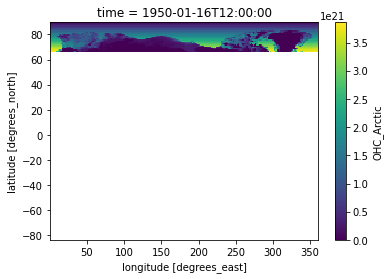

In [ ]:
ds.OHC_Arctic.sel(time = '1950-01-16',method = 'nearest').plot()

Same as the previous steps, we analyse its trend before we do the linear regression

In [ ]:
OHC_Indian = ds.OHC_Indian.sum('lat').sum('lon')
OHC_Pacific = ds.OHC_Pacific.sum('lat').sum('lon')
OHC_Atlantic = ds.OHC_Atlantic.sum('lat').sum('lon')
OHC_Arctic = ds.OHC_Arctic.sum('lat').sum('lon')

Text(0.5, 1.0, 'Pantadal linear regression')

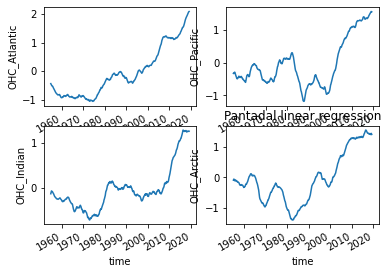

In [ ]:
plt.subplot(2, 2, 1)
standardize(OHC_Atlantic).rolling(time=60).mean().plot()
plt.subplot(2, 2, 2)
standardize(OHC_Pacific).rolling(time=60).mean().plot()
plt.subplot(2, 2, 3)
standardize(OHC_Indian).rolling(time=60).mean().plot()
plt.subplot(2, 2, 4)
standardize(OHC_Arctic).rolling(time=60).mean().plot()
plt.title('Pantadal linear regression')

Linear regression over the four regions

In [ ]:
model_Indian = LinearRegression()
model_Indian.fit(np.arange(0,832).reshape(-1,1)[720:],OHC_Indian.loc["2010-01-16":"2019-04-16"])
OHC_Indian_hat = model_Indian.predict(np.arange(0,832).reshape(-1,1))


<Figure size 432x288 with 0 Axes>

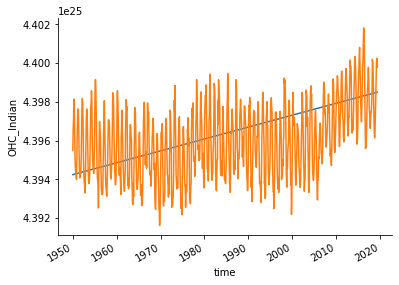

In [ ]:
plt.figure()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(ohc.time,OHC_Indian_hat)
OHC_Indian.plot()

In [ ]:
model_Indian.coef_

array([5.12020387e+19])

In [ ]:
model_Atlantic = LinearRegression()
model_Atlantic.fit(np.arange(0,832).reshape(-1,1)[(OHC_Atlantic.size-OHC_Atlantic.loc["1975-01-16":"2019-04-16"].size):],OHC_Atlantic.loc["1975-01-16":"2019-04-16"])
OHC_Atlantic_hat = model_Atlantic.predict(np.arange(0,832).reshape(-1,1))

<Figure size 432x288 with 0 Axes>

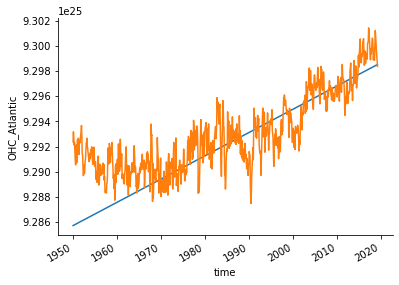

In [ ]:
plt.figure()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(ohc.time,OHC_Atlantic_hat)
OHC_Atlantic.plot()

In [ ]:
model_Atlantic.coef_

array([1.54128898e+20])

In [ ]:
model_Arctic = LinearRegression()
model_Arctic.fit(np.arange(0,832).reshape(-1,1)[(OHC_Arctic.size-OHC_Arctic.loc["1980-01-16":"2019-04-16"].size):],OHC_Arctic.loc["1980-01-16":"2019-04-16"])
OHC_Arctic_hat = model_Arctic.predict(np.arange(0,832).reshape(-1,1))

<Figure size 432x288 with 0 Axes>

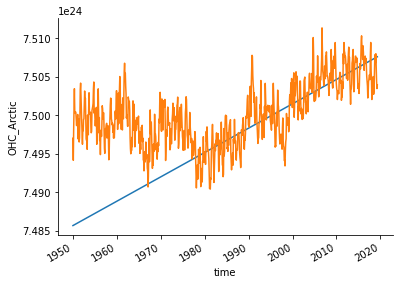

In [ ]:
plt.figure()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(ohc.time,OHC_Arctic_hat)
OHC_Arctic.plot()

In [ ]:
model_Arctic.coef_

array([2.63696404e+19])

In [ ]:
model_Pacific = LinearRegression()
model_Pacific.fit(np.arange(0,832).reshape(-1,1)[(OHC_Pacific.size-OHC_Pacific.loc["1990-01-16":"2019-04-16"].size):],OHC_Pacific.loc["1990-01-16":"2019-04-16"])
OHC_Pacific_hat = model_Pacific.predict(np.arange(0,832).reshape(-1,1))

<Figure size 432x288 with 0 Axes>

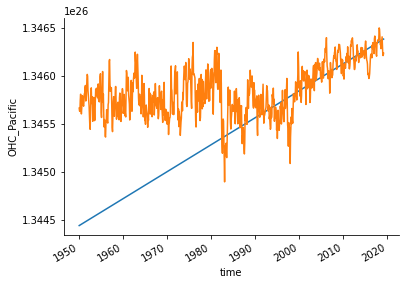

In [ ]:
plt.figure()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(ohc.time,OHC_Pacific_hat)
OHC_Pacific.plot()

In [ ]:
model_Pacific.coef_

array([2.33844028e+20])

In [ ]:
OHC_Indian_2100 = model_Indian.predict(np.array((2100-1950)*12+1).reshape(-1,1))
OHC_Atlantic_2100 = model_Atlantic.predict(np.array((2100-1950)*12+1).reshape(-1,1))
OHC_Arctic_2100 = model_Arctic.predict(np.array((2100-1950)*12+1).reshape(-1,1))
OHC_Pacific_2100 = model_Pacific.predict(np.array((2100-1950)*12+1).reshape(-1,1))

In [ ]:
delta_OHC_In = OHC_Indian_2100-OHC_Indian.sel(time = '1950-01-16',method = 'nearest').values
delta_OHC_At = OHC_Atlantic_2100-OHC_Atlantic.sel(time = '1950-01-16',method = 'nearest').values
delta_OHC_Ar = OHC_Arctic_2100-OHC_Arctic.sel(time = '1950-01-16',method = 'nearest').values
delta_OHC_Pa = OHC_Pacific_2100-OHC_Pacific.sel(time = '1950-01-16',method = 'nearest').values

In [ ]:
print(delta_OHC_In)
print(delta_OHC_At)
print(delta_OHC_Ar)
print(delta_OHC_Pa)
print(delta_OHC_In/(OHC_Indian.sel(time = '1950-01-16',method = 'nearest').values)*100)
print(delta_OHC_At/(OHC_Atlantic.sel(time = '1950-01-16',method = 'nearest').values)*100)
print(delta_OHC_Ar/(OHC_Arctic.sel(time = '1950-01-16',method = 'nearest').values)*100)
print(delta_OHC_Pa/(OHC_Pacific.sel(time = '1950-01-16',method = 'nearest').values)*100)

[7.97829054e+22]
[2.10892448e+23]
[3.61517963e+22]
[2.98763161e+23]
[0.18151078]
[0.22695189]
[0.4822144]
[0.22201846]


Comments : Despite the very rough division, we can see that there are significant differences in the variations of these four parts of the OHC . Please allow me to call them as : Pacifc ocean, Atlantic ocean, Indian ocean and Arctic ocean . In terms of real growth, the order is : 1.Pacific ocean(2.99e23J)  
2.Atlantic ocean(2.11e23J)  
3.Indian ocean(7.98e22J)  
4.Arctic ocean(3.62e22J)  
In terms of percentage growth:  
1.Arctic ocean(0.482%)  
2.Atlantic ocean(0.226%)  
3.Pacific ocean(0.222%)  
4.Indian ocean(0.182%)  